In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as df
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'JUBLPHARMA.NS'

In [19]:
#last 5 years data with interval of 1 day
end_date = dt.datetime.strptime("2022-04-01", "%Y-%m-%d").date()
start_date=end_date-dt.timedelta(days=365*5)
data = yf.download(tickers=stock_symbol,start=start_date,end=end_date,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [20]:
type(data)

pandas.core.frame.DataFrame

In [21]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-03,803.799988,822.000000,802.000000,818.849976,790.370422,543943
2017-04-05,823.549988,845.000000,805.000000,837.900024,808.757874,1260312
2017-04-06,833.000000,841.299988,820.200012,835.299988,806.248291,831311
2017-04-07,832.400024,844.000000,806.349976,813.549988,785.254761,484915
2017-04-10,816.000000,818.549988,803.000000,813.400024,785.109985,382215


In [22]:
len(data)

1235

In [23]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-25,437.100006,440.000000,428.000000,430.850006,430.850006,201350
2022-03-28,431.500000,433.100006,408.200012,410.350006,410.350006,298520
2022-03-29,414.700012,423.750000,396.200012,399.899994,399.899994,316946
2022-03-30,404.950012,409.899994,393.000000,398.799988,398.799988,248565
2022-03-31,400.000000,403.450012,385.149994,388.149994,388.149994,273138


In [24]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

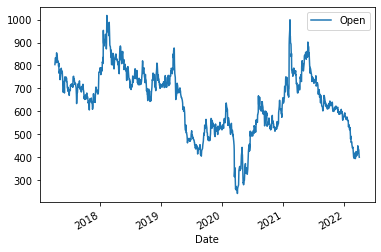

In [25]:
opn.plot()

In [26]:
import matplotlib.pyplot as plt

In [27]:
#close=data[['Close']]
ds = opn.values

In [28]:
ds

array([[803.79998779],
       [823.54998779],
       [833.        ],
       ...,
       [414.70001221],
       [404.95001221],
       [400.        ]])

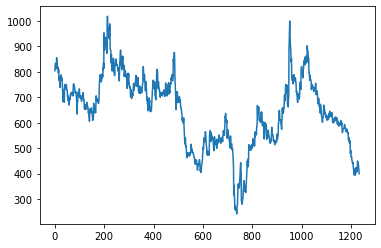

In [29]:
plt.plot(ds)

In [30]:
import numpy as np

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [33]:
print(ds_scaled)

[[0.72403348]
 [0.74948451]
 [0.76166236]
 ...
 [0.22261599]
 [0.21005156]
 [0.20367268]]


In [34]:
len(ds_scaled), len(ds)

(1235, 1235)

In [35]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [36]:
train_size,test_size

(864, 371)

In [37]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [38]:
len(ds_train),len(ds_test)

(864, 371)

In [39]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [40]:
#Taking 100 days price as one record for training
time_stamp = 30
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [41]:
X_train.shape,y_train.shape

((833, 30), (833,))

In [42]:
X_test.shape, y_test.shape

((340, 30), (340,))

In [43]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [45]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Training model with adam optimizer and mean squared error loss function
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=80,batch_size=64,verbose=1)

Epoch 1/80
14/14 [==============================] - 5s 111ms/step - loss: 0.0826 - val_loss: 0.0201
Epoch 2/80
14/14 [==============================] - 1s 43ms/step - loss: 0.0126 - val_loss: 0.0076
Epoch 3/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 4/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 5/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 6/80
14/14 [==============================] - 1s 41ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 7/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 8/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/80
14/14 [==============================] - 1s 40ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 10/80
14/14 [==============================] - 1s 41ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 11

In [47]:
model.save('keras.model.h5')

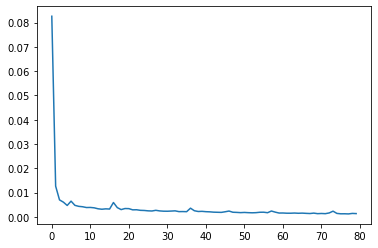

In [48]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [49]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [50]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [51]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

644.9237067558885

In [52]:
math.sqrt(mean_squared_error(y_test,test_predict))

653.961360972263

In [53]:
look_back=30
trainPredictPlot = np.empty_like(ds_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(ds_scaled)-1,:] = test_predict

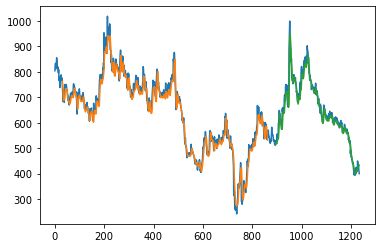

In [54]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [55]:
type(train_predict)

numpy.ndarray

In [56]:
test = np.vstack((train_predict,test_predict))

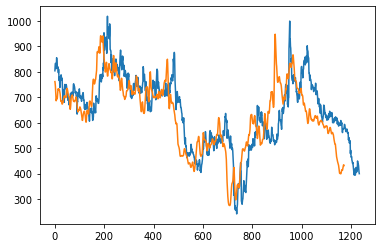

In [57]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [58]:
len(ds_test)

371

In [59]:
#Getting the last 100 days records
n=len(ds_test)-30
print(n)
fut_inp = ds_test[n:]
len(fut_inp)

341


30

In [60]:
fut_inp = fut_inp.reshape(1,-1)

In [61]:
tmp_inp = list(fut_inp)

In [62]:
fut_inp.shape

(1, 30)

In [63]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [64]:
#Predicting next 30 days price using the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(tmp_inp)>30):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.22398999333381653], [0.21701891720294952], [0.21316170692443848], [0.211130753159523], [0.21007369458675385], [0.2095171958208084], [0.20924080908298492], [0.20913474261760712], [0.20914226770401], [0.2092214822769165], [0.20934662222862244], [0.20950892567634583], [0.20965547859668732], [0.20976696908473969], [0.20985233783721924], [0.20991016924381256], [0.20995382964611053], [0.2099737823009491], [0.20996709167957306], [0.20992590487003326], [0.20987848937511444], [0.20982441306114197], [0.20977316796779633], [0.20975981652736664], [0.20974315702915192], [0.20972172915935516], [0.20972006022930145], [0.2097235918045044], [0.20972010493278503], [0.2097163200378418]]


In [65]:
len(ds_scaled)

1235

In [66]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [67]:
print(len(lst_output))
print(normalizer.inverse_transform(lst_output))

30
[[415.76623519]
 [410.35668001]
 [407.36348477]
 [405.78746462]
 [404.96718715]
 [404.5353441 ]
 [404.32086799]
 [404.23856041]
 [404.24439988]
 [404.30587039]
 [404.40297899]
 [404.52892647]
 [404.64265154]
 [404.72916816]
 [404.79541431]
 [404.84029148]
 [404.87417196]
 [404.88965522]
 [404.8844633 ]
 [404.85250233]
 [404.81570791]
 [404.77374469]
 [404.73397849]
 [404.72361777]
 [404.71069   ]
 [404.69406198]
 [404.69276689]
 [404.69550739]
 [404.69280158]
 [404.6898645 ]]


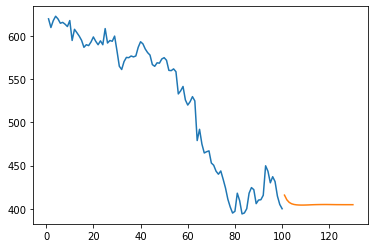

In [68]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[ds_scaled.size-100:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [69]:
ds_new = ds_scaled.tolist()

In [70]:
len(ds_new)

1235

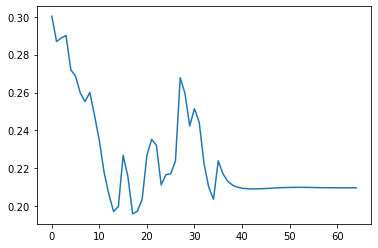

In [71]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [72]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

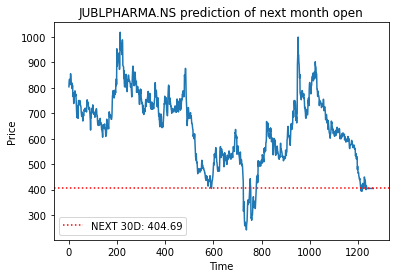

In [73]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

